Text(0.5, 1.0, 'Pacejka tire model')

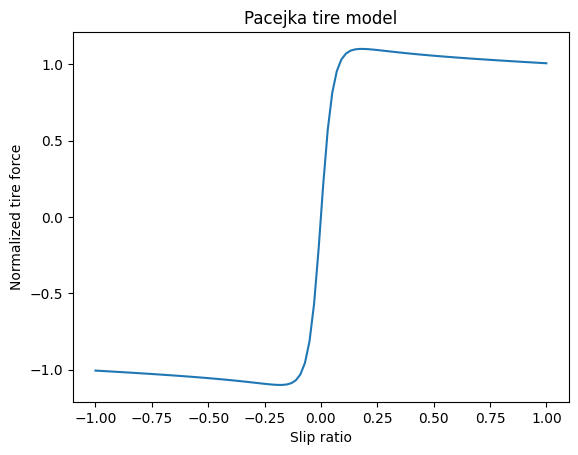

In [10]:
# Plot Pacejka example:

B = 10
C = 1.9
D = 1.1
E = 0.97

import numpy as np
import matplotlib.pyplot as plt

def pacejka(x):
    return D*np.sin(C*np.arctan(B*x - E*(B*x - np.arctan(B*x))))

x = np.linspace(-1, 1, 100)
y = pacejka(x)

plt.plot(x, y)
plt.xlabel('Slip ratio')
plt.ylabel('Normalized tire force')
plt.title('Pacejka tire model')


              time   f_x   f_y  steering_angle
0     1.698161e+09  0.19 -3.54       -0.071792
1     1.698161e+09  2.51 -5.01       -0.071792
2     1.698161e+09  1.95  9.10       -0.071792
3     1.698161e+09 -0.07  2.63       -0.071792
4     1.698161e+09 -0.07  2.63       -0.071792
...            ...   ...   ...             ...
3758  1.698161e+09  0.00  0.07       -0.036890
3759  1.698161e+09 -0.02  0.07       -0.036890
3760  1.698161e+09 -0.02  0.06       -0.036890
3761  1.698161e+09  0.03  0.09       -0.036890
3762  1.698161e+09 -0.02  0.06       -0.036890

[3763 rows x 4 columns]


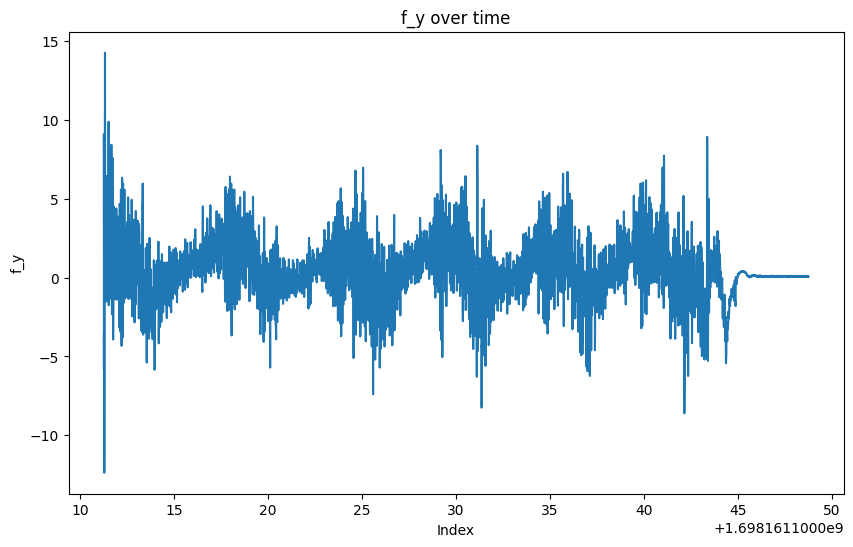

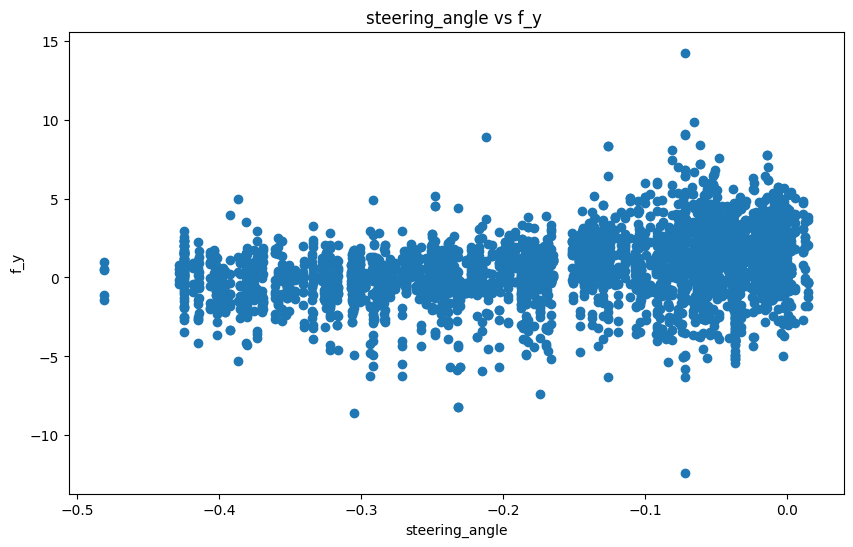

In [46]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

bag = rosbag.Bag('./data/pp_ETF1_2023-10-24-17-25-09.bag')

imu_data = []
car_state_data = []

for topic, msg, t in bag.read_messages(topics=['/imu/data', '/car_state/tum_state']):
    if topic == '/imu/data':
        imu_data.append({'time': t.to_sec(), 'f_x': msg.linear_acceleration.x, 'f_y': msg.linear_acceleration.y})
    elif topic == '/car_state/tum_state':
        # Assuming msg has attributes x, y
        car_state_data.append({'time': t.to_sec(), 'steering_angle': msg.steering_angle})

imu_df = pd.DataFrame(imu_data)

def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

window_size = 1000  # Set the window size for the moving average filter
for column in imu_df.columns:
    imu_df[column] = moving_average(imu_df[column], window_size)
    
    
# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Apply the filter to all columns of imu_df
for column in imu_df.columns:
    imu_df[column] = butter_lowpass_filter(imu_df[column], cutoff, fs, order)

car_state_df = pd.DataFrame(car_state_data)

imu_df = pd.DataFrame(imu_data).set_index('time')
car_state_df = pd.DataFrame(car_state_data).set_index('time')

# Merge the two dataframes on the 'time' column
merged_df = pd.merge_asof(imu_df, car_state_df, on='time', direction='nearest')

bag.close()


print(merged_df)


plt.figure(figsize=(10, 6))
plt.plot(imu_df['f_y'])
plt.title('f_y over time')
plt.xlabel('Index')
plt.ylabel('f_y')
plt.show()



plt.figure(figsize=(10, 6))
plt.scatter(merged_df['steering_angle'], merged_df['f_y'])
plt.title('steering_angle vs f_y ')
plt.xlabel('steering_angle')
plt.ylabel('f_y')
plt.show()

In [ ]:
from scipy.signal import freqz
import numpy as np

w, h = freqz(b, a, worN=8000)

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

plt.subplot(2, 1, 2)
angles = np.unwrap(np.angle(h))
plt.plot(0.5*fs*w/np.pi, angles, 'g')
plt.xlim(0, 0.5*fs)
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.xlabel('Frequency [Hz]')
plt.show()